# **DCGAN: Train & Adapt with `MNIST`**

## **Import libraries**

In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import time

# # Set random seed for reproducibility
# manualSeed = 5
# #manualSeed = random.randint(1, 10000) # use if you want new results
# print("Random Seed: ", manualSeed)
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)
# torch.use_deterministic_algorithms(True) # Needed for reproducible results

In [2]:
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
# image_size = 28 # Mnist

# Batch size during training
batch_size = 64

# Number of workers for dataloader
workers = 2

## **Data**

- Chuẩn bị dữ liệu, dữ liệu là ảnh phải nằm trong duy nhất một folder.
- Dữ liệu đã sử dụng: https://www.kaggle.com/datasets/hojjatk/mnist-dataset

In [9]:
# Root directory for dataset
dataroot = "MNISTDigit"

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.MNIST(root=dataroot,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,))
                      ]),
                     download=True
                    )

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.19MB/s]


Extracting MNISTDigit\MNIST\raw\train-images-idx3-ubyte.gz to MNISTDigit\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 108kB/s]


Extracting MNISTDigit\MNIST\raw\train-labels-idx1-ubyte.gz to MNISTDigit\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:02<00:00, 762kB/s] 


Extracting MNISTDigit\MNIST\raw\t10k-images-idx3-ubyte.gz to MNISTDigit\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]

Extracting MNISTDigit\MNIST\raw\t10k-labels-idx1-ubyte.gz to MNISTDigit\MNIST\raw



## **Architecture**

In [3]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [3]:
# Kích thước của Latent Vector
nz = 100

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz, 128, 4, 2, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 4 x 4

            nn.ConvTranspose2d(128, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 7 x 7

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. 32 x 14 x 14

            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.model(input)

### Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # input is 1 x 28 x 28

            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 32 x 14 x 14

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64) x 7 x 7

            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 4 x 4

            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [6]:
# Thiết bị sử dụng
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [16]:
# Tạo mạng G
netG = Generator().to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

print(netG)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [17]:
# Tạo mạng D
netD = Discriminator().to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

print(netD)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


### Loss function

- Sử dụng Binary Cross Entropy (BCE) <br>
$$\ell(x, y) = L = \{ l_1, \dots, l_N \}^\top, \quad l_n = -[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) ]$$


In [7]:
criterion = nn.BCELoss()

# Create a batch (64) of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Setup Adam optimizers for both G and D
# optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## **Normal train**

In [ ]:
num_epochs = 50

c_optimizer = optimizerG.__class__.__name__ # Adam | SGD
c_lr = str(optimizerD.param_groups[0]['lr']).replace(".", "") # 00002 | 00004 ...

print("-- Epochs: ", num_epochs)
print("-- Current z_dim: ", nz)
print("-- Current optimizer & learning rate: ", c_optimizer, c_lr)
print("-- Is training netG: ", netG.training)
print("-- Is training netD: ", netD.training)
print("-- Device: ", device)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

ttrain_D, ttrain_G, ttrain_GAN = 0, 0, 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, _) in enumerate(dataloader):
        # print(i)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tD_start = time.time()
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        tD_end = time.time()
        ttrain_D += tD_end - tD_start

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        tG_start = time.time()
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        tG_end = time.time()
        ttrain_G += tG_end - tG_start

        ttrain_GAN = ttrain_D + ttrain_G

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    # Lưu trọng số G tại epoch 10 và 50
    if epoch == 10 or epoch == 50:
        torch.save(netG.state_dict(), f"{save_dir}/generator_epoch_{epoch}.pth")

print(f">> GAN training time: {ttrain_GAN}")
print(f"  -- Discriminator training time: {ttrain_D}")
print(f"  -- Generator training time: {ttrain_G}")

In [21]:
torch.save(netG.state_dict(), f"{save_dir}/generator_epoch_final.pth")
torch.save(netD.state_dict(), f"{save_dir}/discriminator_epoch_final.pth")

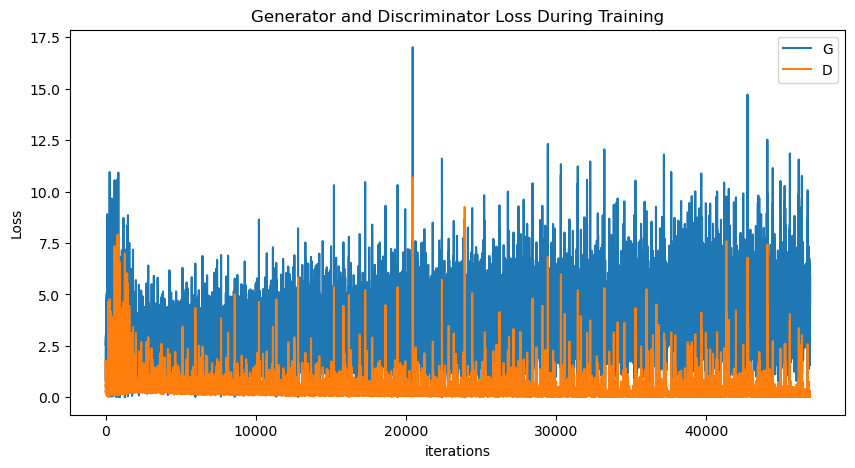

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 50  # Set the limit to 50 MB

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

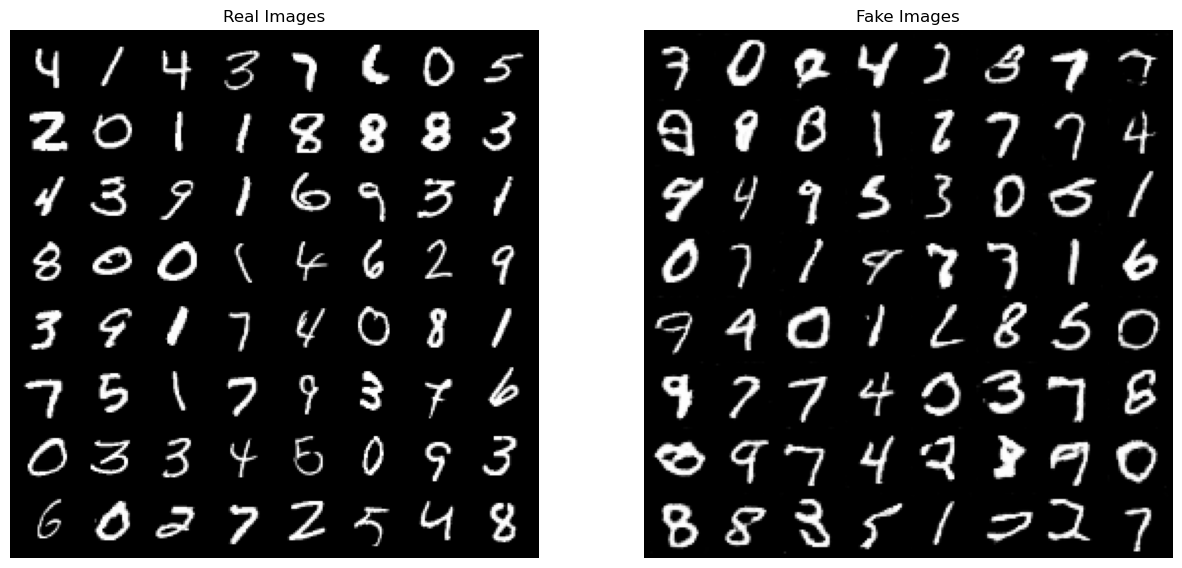

In [23]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## **Adapt with digit `1`**

In [8]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

G_final = Generator().to(device)
D_final = Discriminator().to(device)

# Tải trọng số vào mô hình
save_dir = "checkpoints"
G_final.load_state_dict(torch.load(f'{save_dir}/generator_epoch_final.pth'))
D_final.load_state_dict(torch.load(f'{save_dir}/discriminator_epoch_final.pth'))

cuda:0


C:\Users\Admin\AppData\Local\Temp\ipykernel_12260\163911788.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_final.load_state_dict(torch.load(f'{save_dir}/generator_epo

<All keys matched successfully>

In [9]:
import torch.autograd as autograd
from PIL import Image

class EWC:
    """
    Class for performing Elastic Weight Consolidation
    Reference link:
        https://discuss.pytorch.org/t/implementation-of-elastic-weight-consolidation-fisher-information-matrix/9309/3 
    """

    def __init__(self, model_anchor):
        self._model_anchor = model_anchor
        self._params_anchor = {n: p for n, p in model_anchor.named_parameters()}
        self._fishers, self._mean_fishers = None, None


    def _calc_fisher(self, likelihood, nsample=1):
        # TODO: Process unused params case
        grads = autograd.grad(likelihood, self._model_anchor.parameters())
        _fishers = [(g**2)/nsample for g in grads]

        param_names = [name for name, _ in self._model_anchor.named_parameters()]
        fs_dict = {n: f for n, f in zip(param_names, _fishers)}

        return fs_dict
    

    def set_fisher(self, likelihood, nsample=1):
        self._fishers = self._calc_fisher(likelihood, nsample=nsample)


    def get_fisher(self): return self._fishers

    
    def calc_ewc(self, model, weight=5e8, batch_size=32):
        params = {n: p for n, p in model.named_parameters()}

        ewc = 0
        for name in self._fishers:
            _ewc = self._fishers[name]*(params[name] - self._params_anchor[name])**2
            ewc += _ewc.sum()
        ewc /= batch_size
        return weight*ewc


def loss_adapt(l_adv, ewc, model, batch_size=32, weight=5e8):
    l_ewc = ewc.calc_ewc(model, weight=weight, batch_size=batch_size)
    return l_adv + l_ewc, l_ewc


def make_image_plot(file_path, generator, examples=25, latent_size=512, dim=(5,5), figsize=(10,10)):
    noise= torch.randn(examples, latent_size).to(device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()
    plt.figure(figsize=figsize)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


    for i in range(generated_images.shape[0]):
        plt.subplot(5, 5, i + 1)
        image = generated_images[i].permute(1,2,0)
        plt.imshow(image,interpolation='nearest',cmap='gray_r')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(file_path)
    plt.close('all')


def make_train_summary_plot(histories, colors, labels):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(histories[0]) + 1), histories[0], color=colors[0], label=labels[0])
    plt.plot(range(1, len(histories[1]) + 1), histories[1], color=colors[1], label=labels[1])
    plt.title('Generator Loss During Adaptation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    


def generate_folder(generator, folderpath, examples=25, latent_size=100):
    noise = torch.randn(examples, latent_size, 1, 1, device=device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()


    for i in range(generated_images.shape[0]):
        file_name = f"{i}.jpg"
        image = generated_images[i].permute(1,2,0)
        image = image.numpy()
        image = image.reshape(image.shape[0], image.shape[1])
        plt.imsave(os.path.join(folderpath, file_name), image, cmap="gray")


def param_diff(model0, model1):
    params0 = {n: p for n, p in model0.named_parameters()}
    params1 = {n: p for n, p in model1.named_parameters()}

    param_diffs = []
    for name in params0:
        dparam = ((params0[name] - params1[name])**2).mean().detach().cpu()
        param_diffs.append(dparam**2)

    return param_diffs

In [10]:
generate_folder(G_final, folderpath="generated_preadapt", examples=1000)

In [11]:
# Root directory for dataset
# Select generated images with undesired features and move to this folder (anyname)
# adapt/subfolder/
dataroot = "adapt/"

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.Resize((28, 28)), 
        transforms.Grayscale()
    ])
)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10,
                                         shuffle=True)

print(len(dataloader))

6


### `G` EWC

>>> likelihood tensor(5.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


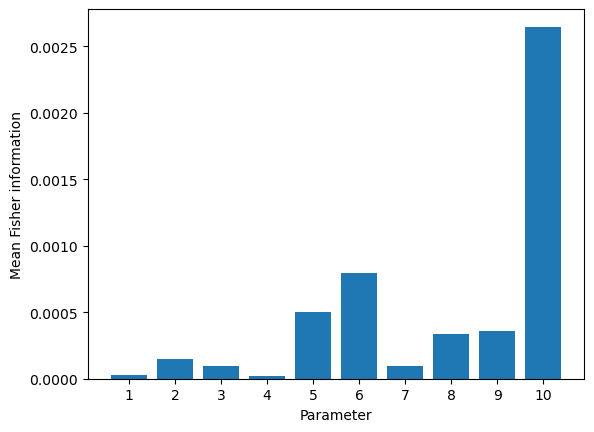

In [12]:
from copy import deepcopy

ewc = EWC(G_final)

# Generate sample input and output
noise = torch.randn(300, nz, 1, 1, device=device)
output_d = D_final(G_final(noise)).view(-1)
real_label = torch.full((300, ), 0.99, dtype=torch.float).to(device)

# Error between Discriminator output and actual label
likelihood = criterion(output_d, real_label)
print(">>> likelihood", likelihood)

# Compute Fisher information for each parameter
ewc.set_fisher(likelihood, nsample=300)
fishers = ewc.get_fisher()

# Plot mean Fisher information
fisher_vals = [fishers[n].mean().detach().cpu() for n in fishers]
plt.bar(np.arange(len(fisher_vals)) + 1, fisher_vals)
plt.xticks(np.arange(len(fisher_vals)) + 1)
plt.xlabel("Parameter")
plt.ylabel("Mean Fisher information")

# Example value for adversarial loss
# NOTE: Will need to change formula in actual training
l_adv = criterion(output_d, real_label)

generator_new = deepcopy(G_final)
l_adapt, l_ewc = loss_adapt(l_adv, ewc, generator_new, batch_size=300)

optimizerG_new = optim.Adam(generator_new.parameters(), lr=lr, betas=(beta1, 0.999))

### `D` EWC

>>> likelihood tensor(5.5320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


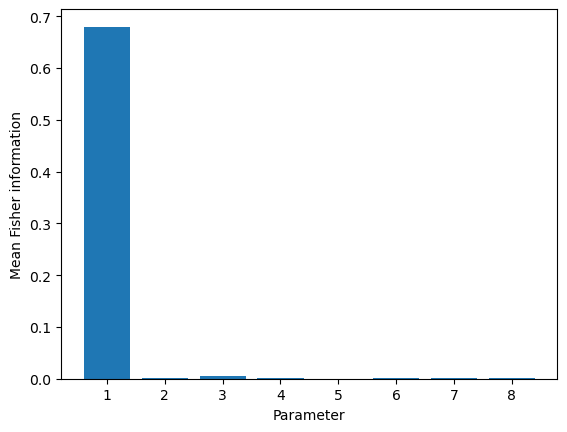

In [13]:
ewc_d = EWC(D_final)

# Generate sample input and output
noise = torch.randn(600, nz, 1, 1, device=device)
output_d = D_final(G_final(noise)).view(-1)
real_label = torch.full((600, ), 0.99, dtype=torch.float).to(device)

# Error between Discriminator output and actual label
likelihood = criterion(output_d, real_label)
print(">>> likelihood", likelihood)

# Compute Fisher information for each parameter
ewc_d.set_fisher(likelihood, nsample=600)
fishers = ewc_d.get_fisher()

# Plot mean Fisher information
fisher_vals = [fishers[n].mean().detach().cpu() for n in fishers]
plt.bar(np.arange(len(fisher_vals)) + 1, fisher_vals)
plt.xticks(np.arange(len(fisher_vals)) + 1)
plt.xlabel("Parameter")
plt.ylabel("Mean Fisher information")

# Example value for adversarial loss
# NOTE: Will need to change formula in actual training
l_adv = criterion(output_d, real_label)

discriminator_new = deepcopy(D_final)
l_adapt, l_ewc = loss_adapt(l_adv, ewc_d, discriminator_new, batch_size=300)

optimizerD_new = optim.Adam(discriminator_new.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
# Tạo thư mục lưu trọng số nếu chưa tồn tại (gồm các bộ trọng số Generator tại các epoch khác)
save_dir = "checkpoints_adapt"
os.makedirs(save_dir, exist_ok=True)

### Adaptation thingamajic

In [15]:
num_epochs = 2000

c_optimizer = optimizerG_new.__class__.__name__ # Adam | SGD
# c_lr = str(optimizerD.param_groups[0]['lr']).replace(".", "") # 00002 | 00004 ...

print("-- Epochs: ", num_epochs)
print("-- Current z_dim: ", nz)
# print("-- Current optimizer & learning rate: ", c_optimizer, c_lr)
print("-- Is training netG: ", generator_new.training)
print("-- Is training netD: ", discriminator_new.training)
print("-- Device: ", device)

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
real_label = 1.0
fake_label = 0.0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data, _) in enumerate(dataloader):
        # print(data.shape)
        # print(i)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_new.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator_new(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        loss_D_real, l_ewc_D = loss_adapt(errD_real, ewc_d, discriminator_new, batch_size=b_size, weight=5e6)
        loss_D_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator_new(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator_new(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        # loss_D_fake, l_ewc_D = loss_adapt(errD_fake, ewc_d, discriminator_new, batch_size=b_size, weight=5e6)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = loss_D_real + errD_fake
        # Update D
        optimizerD_new.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        tG_start = time.time()
        generator_new.zero_grad()
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = generator_new(noise)
        output = discriminator_new(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        loss_G, l_ewc = loss_adapt(errG, ewc, generator_new, batch_size=b_size, weight=1e5)
        # Calculate gradients for G
        loss_G.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG_new.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_G: %.4f\tD(G(z)): %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                    errG.item(), D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator_new(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    # Lưu trọng số G tại epoch 10 và 50
    if epoch == 10 or epoch == 50:
        torch.save(generator_new.state_dict(), f"{save_dir}/generator_adapt_epoch_{epoch}.pth")

-- Epochs:  2000
-- Current z_dim:  100
-- Is training netG:  True
-- Is training netD:  True
-- Device:  cuda:0
Starting Training Loop...
[0/2000][0/6]	Loss_G: 3.6224	D(G(z)): 0.0623
[1/2000][0/6]	Loss_G: 7.8996	D(G(z)): 0.0005
[2/2000][0/6]	Loss_G: 0.8090	D(G(z)): 0.4911
[3/2000][0/6]	Loss_G: 5.1088	D(G(z)): 0.0084
[4/2000][0/6]	Loss_G: 7.3029	D(G(z)): 0.0015
[5/2000][0/6]	Loss_G: 6.0556	D(G(z)): 0.0047
[6/2000][0/6]	Loss_G: 5.7361	D(G(z)): 0.0160
[7/2000][0/6]	Loss_G: 6.7114	D(G(z)): 0.0018
[8/2000][0/6]	Loss_G: 4.2251	D(G(z)): 0.0256
[9/2000][0/6]	Loss_G: 5.6494	D(G(z)): 0.0109
[10/2000][0/6]	Loss_G: 6.2696	D(G(z)): 0.0026
[11/2000][0/6]	Loss_G: 3.1645	D(G(z)): 0.0945
[12/2000][0/6]	Loss_G: 4.4623	D(G(z)): 0.0157
[13/2000][0/6]	Loss_G: 6.0388	D(G(z)): 0.0064
[14/2000][0/6]	Loss_G: 6.2449	D(G(z)): 0.0114
[15/2000][0/6]	Loss_G: 5.2147	D(G(z)): 0.0138
[16/2000][0/6]	Loss_G: 9.3364	D(G(z)): 0.0002
[17/2000][0/6]	Loss_G: 3.3049	D(G(z)): 0.0550
[18/2000][0/6]	Loss_G: 2.2326	D(G(z)): 0.18

KeyboardInterrupt: 

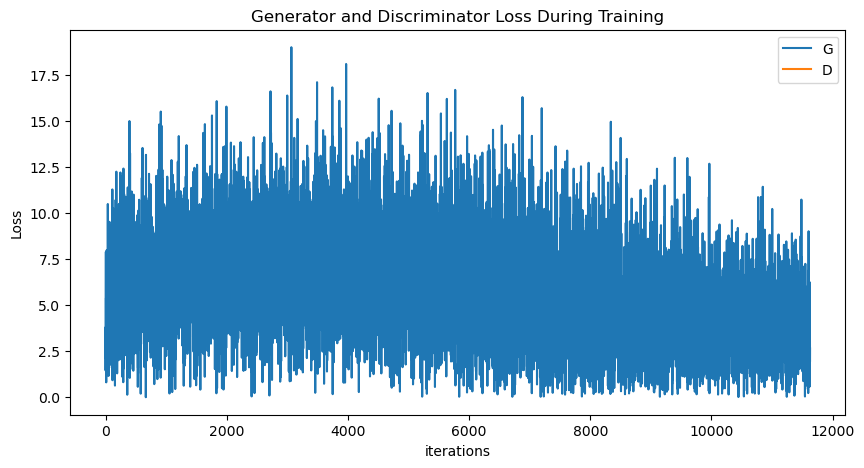

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)
ani.save("gan_adapt_mnist1.gif")
HTML(ani.to_jshtml())

Text(0, 0.5, 'Mean Squared Difference')

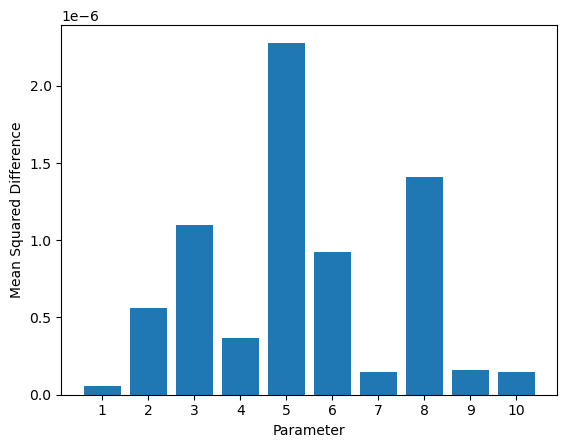

In [61]:
dparams = param_diff(generator_new, G_final)
plt.bar(np.arange(len(dparams)) + 1, dparams)
plt.xticks(np.arange(len(dparams)) + 1)
plt.xlabel("Parameter")
plt.ylabel("Mean Squared Difference")

In [18]:
torch.save(generator_new.state_dict(), f"{save_dir}/generator_adapted_mnist1_D-1ewc.pth")
torch.save(discriminator_new.state_dict(), f"{save_dir}/discriminator_adapted_mnist1_D-1ewc.pth")

In [19]:
generate_folder(generator_new, folderpath="generated_adapted_D-1ewc", examples=800)